In [130]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [131]:
%pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [132]:
import librosa

In [133]:
SAMPLE_RATE = 16000

In [134]:
marvin = os.path.join('marvin','0a7c2a8d_nohash_0.wav')

In [135]:
#resampling function
def resample_1d(wav, rate_in, rate_out):
    rate_in = tf.cast(rate_in, tf.float32)
    rate_out = tf.cast(rate_out, tf.float32)

    n_samples = tf.cast(tf.shape(wav)[0], tf.float32)
    n_out = tf.cast(tf.math.round(n_samples * rate_out / rate_in), tf.int32)

    # Original sample positions
    x_old = tf.linspace(0.0, n_samples - 1, tf.cast(n_samples, tf.int32))
    # New sample positions
    x_new = tf.linspace(0.0, n_samples - 1, n_out)

    wav = tf.expand_dims(wav, axis=0)
    wav = tf.expand_dims(wav, axis=-1)

    resampled = tf.image.resize(
        wav,
        size=[n_out, 1],
        method="bilinear"
    )

    return tf.squeeze(resampled)


In [136]:
#loading the wav file
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)

    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1
    )

    wav = tf.squeeze(wav, axis=-1)  # (samples,)

    # 🔑 IMPORTANT: only resample if needed
    sample_rate = tf.cast(sample_rate, tf.int32)

    def resample():
        # put your resampling code here ONLY if sr != 16000
        return wav  # placeholder if you removed tfio

    wav = tf.cond(
        tf.not_equal(sample_rate, 16000),
        true_fn=resample,
        false_fn=lambda: wav
    )

    return wav

In [137]:
import soundfile as sf

In [138]:
#spliting the all noise clips to create a negative dataset
noise_clips = [
    'doing_the_dishes.wav',
    'dude_miaowing.wav',
    'exercise_bike.wav',
    'pink_noise.wav',
    'running_tap.wav'
]

output_dir = "noise"
chunk_size = 16000
target_sr = 16000

os.makedirs(output_dir, exist_ok=True)

clip_id = 0

for fname in noise_clips:
    path = os.path.join(fname)

    #librosa → mono + resample to 16kHz
    audio, sr = librosa.load(path, sr=target_sr, mono=True)

    for i in range(0, len(audio), chunk_size):
        chunk = audio[i:i + chunk_size]

        if len(chunk) == chunk_size:
            sf.write(
                os.path.join(output_dir, f"noise_{clip_id}.wav"),
                chunk,
                target_sr
            )
            clip_id += 1

Visulizing the Audio Data

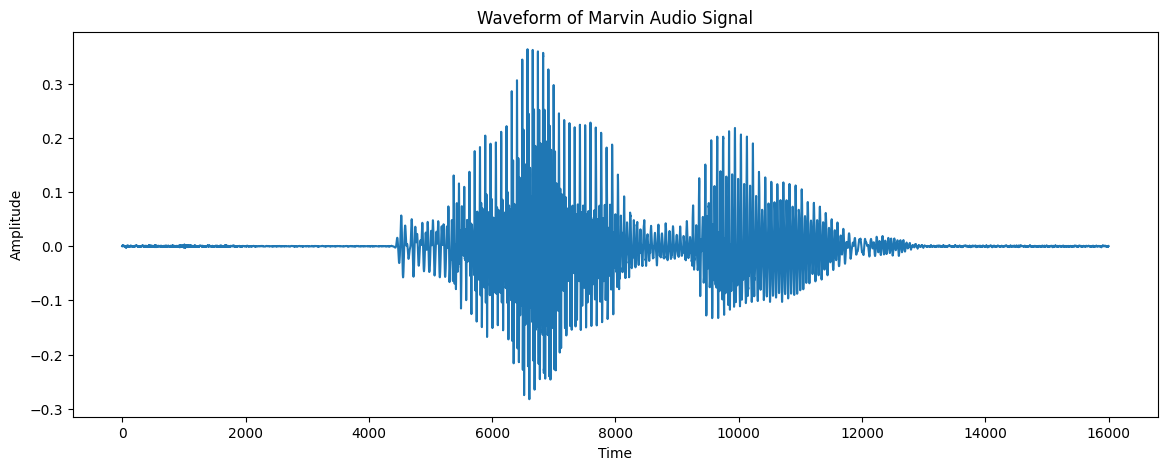

In [139]:
test_file = load_wav_16k_mono(marvin)
plt.figure(figsize=(14, 5))
plt.plot(test_file)
plt.title('Waveform of Marvin Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [140]:
test_file

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-3.0517578e-05,  9.1552734e-05,  7.9345703e-04, ...,
        5.1879883e-04,  7.9345703e-04,  5.4931641e-04], dtype=float32)>

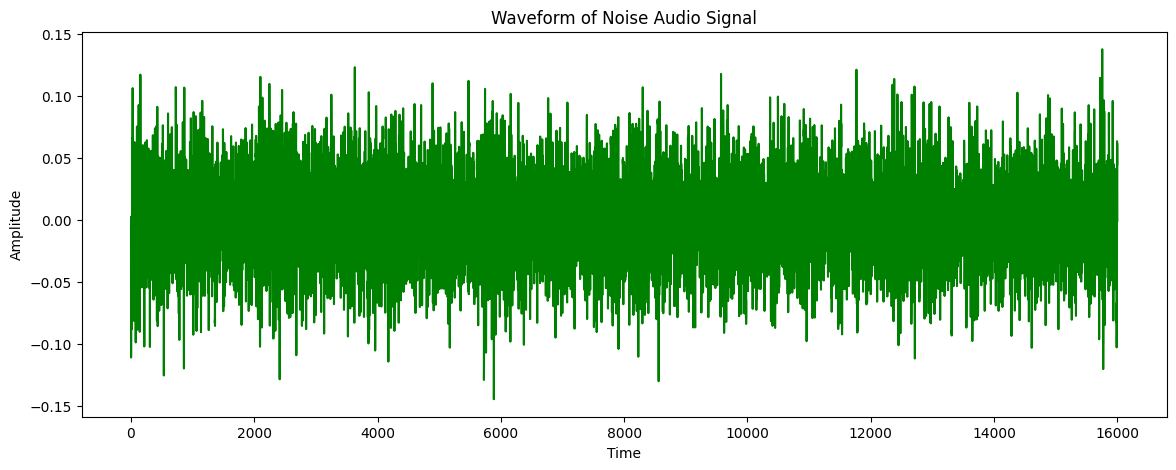

In [141]:
test_file_noise = load_wav_16k_mono(os.path.join('noise','noise_22.wav'))
plt.figure(figsize=(14, 5))
plt.plot(test_file_noise,'g')
plt.title('Waveform of Noise Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [142]:
#creating a positive and negative dataset using marvin and dishes noise
neg = tf.data.Dataset.list_files(os.path.join('noise') + '/*.wav')
pos = tf.data.Dataset.list_files(os.path.join('marvin') + '/*.wav')

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [143]:
positives.as_numpy_iterator().next()

(b'marvin/f618568f_nohash_0.wav', np.float32(1.0))

In [144]:
negatives.as_numpy_iterator().next()

(b'noise/noise_278.wav', np.float32(0.0))

In [145]:
positives = positives.take(338)
data = positives.concatenate(negatives)

In [146]:
FRAME_LENGTH = 640
HOP_LENGTH = 320

In [147]:
#extracting MFCC
def extract_mfcc(
    wav,
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,   # 40 ms
    frame_step=HOP_LENGTH,     # 20 ms
    num_mel_bins=40,
    num_mfcc=13,
    lower_freq=20.0,
    upper_freq=4000.0
):
    stft = tf.signal.stft(
        wav,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )

    spectrogram = tf.abs(stft)

    num_spectrogram_bins = spectrogram.shape[-1]

    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,
        num_spectrogram_bins,
        sample_rate,
        lower_freq,
        upper_freq
    )

    mel_spectrogram = tf.tensordot(
        spectrogram,
        mel_weight_matrix,
        1
    )

    mel_spectrogram.set_shape(
        spectrogram.shape[:-1].concatenate(
            mel_weight_matrix.shape[-1:]
        )
    )
    # 3️⃣ Log-Mel Spectrogram
    log_mel_spectrogram = tf.math.log(
        mel_spectrogram + 1e-6
    )
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrogram
    )
    # Keep first num_mfcc coefficients
    mfccs = mfccs[:, :num_mfcc]

    return mfccs

In [148]:
mfcc_test = extract_mfcc(test_file)
mfcc_test_noise = extract_mfcc(test_file_noise)
mfcc_test.shape

TensorShape([49, 13])

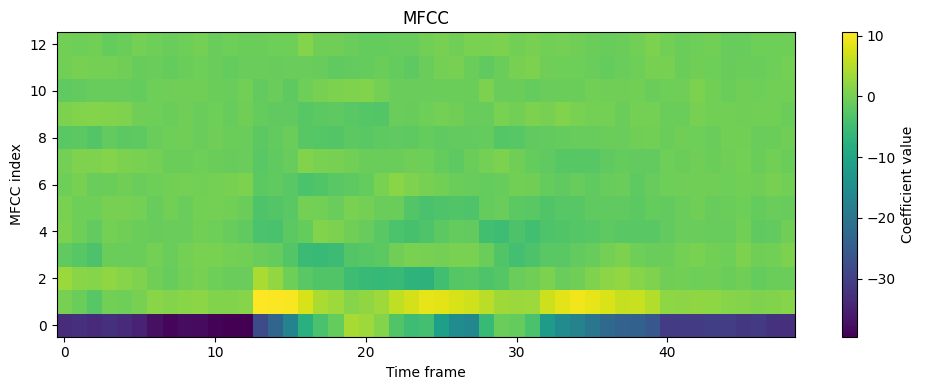

In [149]:
plt.figure(figsize=(10, 4))
plt.imshow(
    mfcc_test.numpy().T,   # transpose so MFCC index is on Y-axis
    aspect="auto",
    origin="lower"
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Time frame")
plt.ylabel("MFCC index")
plt.title("MFCC")
plt.tight_layout()
plt.show()


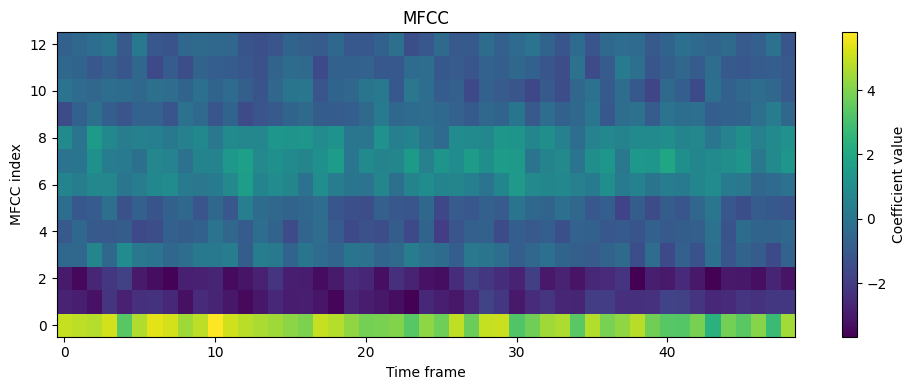

In [150]:
plt.figure(figsize=(10, 4))
plt.imshow(
    mfcc_test_noise.numpy().T,   # transpose so MFCC index is on Y-axis
    aspect="auto",
    origin="lower"
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Time frame")
plt.ylabel("MFCC index")
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [151]:
#preprocessing function
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)

    # Trim to 1 second
    wav = wav[:16000]

    # Pad if shorter
    pad_len = tf.maximum(0, 16000 - tf.shape(wav)[0])
    wav = tf.pad(wav, paddings=[[pad_len, 0]])

    # MFCC extraction → (time_frames, num_mfcc)
    mfcc = extract_mfcc(wav)

    return mfcc, label


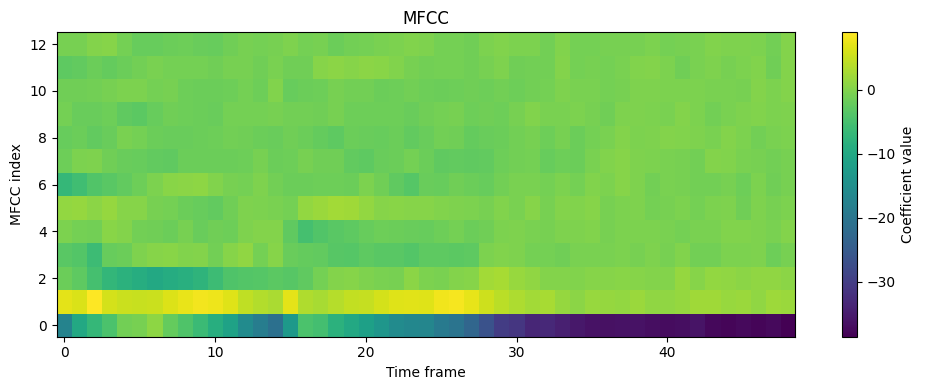

In [152]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
mfcc , label = preprocess(filepath, label)
plt.figure(figsize=(10, 4))
plt.imshow(
    mfcc.numpy().T,  # transpose so MFCC index is on Y-axis
    aspect="auto",
    origin="lower"
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Time frame")
plt.ylabel("MFCC index")
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [153]:
data = (
    data
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
)


In [154]:
#creating a training and validation set
train = data.take(448)
validation = data.skip(448).take(192)



In [155]:
samples, labels = next(iter(train))
labels


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [156]:
#Mean of training set
sum_ = tf.zeros((13,), dtype=tf.float32)
count = 0

for x, y in train:              # x: [B, T, 13]
    sum_ += tf.reduce_sum(x, axis=[0, 1])   # reduce batch + time
    count += tf.shape(x)[0] * tf.shape(x)[1]

mean = sum_ / tf.cast(count, tf.float32)
mean.shape   # (13,)



TensorShape([13])

In [157]:
sum_sq = tf.zeros((13,), dtype=tf.float32)
count_sq = 0

for x, y in train:              # x: [B, T, 13]
    sum_sq += tf.reduce_sum(tf.square(x), axis=[0, 1])
    count_sq += tf.shape(x)[0] * tf.shape(x)[1]

second_moment = sum_sq / tf.cast(count_sq, tf.float32)
second_moment.shape   # (13,)


TensorShape([13])

In [158]:
#standard deviation of training set
std = tf.sqrt(second_moment - mean**2)
std.shape   # (13,)


TensorShape([13])

In [159]:
#Normalization function
EPS = 1e-6

def normalize(x_d, y_d):
    # x_d: [T, 13] or [B, T, 13]
    x_d = (x_d - mean) / (std + EPS)
    return x_d, y_d


In [160]:
train = (
    train
    .map(normalize)
    .batch(32)              # ← SINGLE batch here
    .prefetch(tf.data.AUTOTUNE)
)

validation = (
    validation
    .take(192)
    .map(normalize)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE))


In [161]:
for x, y in train.take(1):
    print(tf.reduce_mean(x, axis=[0, 1]))     # ≈ 0
    print(tf.math.reduce_std(x, axis=[0, 1])) # ≈ 1


tf.Tensor(
[-1.1487477   0.24919295  0.11721589  0.12531705  0.1169272   0.08557513
  0.10295115  0.07976069  0.08635302  0.0905125   0.07422054  0.06931603
  0.0757823 ], shape=(13,), dtype=float32)
tf.Tensor(
[3.8292954  0.48945698 0.37720796 0.22529869 0.23036793 0.19044112
 0.15902549 0.16212788 0.1393914  0.11658962 0.11762983 0.10405926
 0.09794055], shape=(13,), dtype=float32)


In [162]:
sample = next(iter(train))
print(sample[0].shape)


(32, 49, 13)


In [163]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(49, 13, 1)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu',),
    tf.keras.layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [164]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6909 - precision: 0.8207 - recall: 0.1343 - val_loss: 0.6860 - val_precision: 0.9306 - val_recall: 0.6700
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6836 - precision: 0.7436 - recall: 0.9150 - val_loss: 0.6746 - val_precision: 0.7143 - val_recall: 0.9574
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6700 - precision: 0.7451 - recall: 0.8749 - val_loss: 0.6448 - val_precision: 0.7714 - val_recall: 0.8526
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6362 - precision: 0.7621 - recall: 0.8496 - val_loss: 0.5910 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5842 - precision: 0.7720 - recall: 0.7673 - val_loss: 0.5096 - val_precision: 0.8100 - val_recall: 0.7864
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5174 - precision: 0.7474 - recall: 0.8022 - val_loss: 0.4628 - val_precision: 0.7473 - val_recall: 0.7391
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 49, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 49, 13, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 49, 13, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,453 (33.02 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,636 (22.02 KB)

None


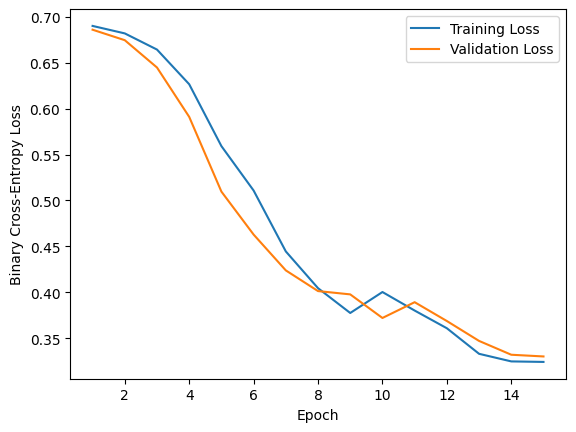

In [165]:
steps_per_epoch = 448 // 32
validation_steps = 192 // 32

history_cnn = model.fit(
    train,
    validation_data=validation,
    epochs=15,
    steps_per_epoch=14,
    validation_steps=6
)

print(model.summary())

epochs = range(1, len(history_cnn.history['loss']) + 1)

plt.figure()
plt.plot(epochs, history_cnn.history['loss'], label='Training Loss')
plt.plot(epochs, history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()




In [175]:
loss, precision, recall = model.evaluate(validation)
print(f"Validation precision: {precision:.3f}, recall: {recall:.3f}")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3543 - precision: 0.8545 - recall: 0.7637 
Validation precision: 0.841, recall: 0.763
